In [42]:
import icarusplot
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import os
from scipy.stats import chi2
import VariableInfoMap
import DataEntryInfoMap
import FitConfigInfoMap
from SelectionInfo import SelectionInfo
from BaseInfo import BaseInfo

In [43]:
WD = '/Users/jskim/Documents/Neutrino/ICARUS/GUNDAM-1.9.X/work/run_configs/BaseConfig_250528'

In [44]:
JobName = '250528_BeamWidthCorrection'
JobName = '250627_BadRegionRejection'

In [45]:
FitOutputBaseDir = f'{WD}/output/{JobName}/Fitter'
ToyOutputBaseDir = f'{WD}/output/{JobName}/ToyGenerator'
XsecOutputBaseDir = f'{WD}/output/{JobName}/CalcXsec'

# Data entry

In [46]:
FitDataType = 'Asimov'
# FitDataType = 'Random15PercentRealData'
# FitDataType = 'RealDataForSideband_FakeDataForSignal'
# FitDataType = 'RealDataForSideband_Random15PercentRealDataForSignal'


dataEntryInfo = DataEntryInfoMap.DataEntryInfoMap[FitDataType]
FitDataTypeLatex = dataEntryInfo.Latex

# Systematics type

In [47]:
# FitConfigType = 'IndvFit_PoissonLLH'
FitConfigType = 'IndvFit_BarlowLLH'

fitConfigInfo = FitConfigInfoMap.FitConfigInfoMap[FitConfigType]
FitConfigTypeLatex = fitConfigInfo.Latex

In [48]:
TopLeftLatex = FitDataTypeLatex
if FitConfigTypeLatex != '':
    TopLeftLatex += '\n%s'%(FitConfigTypeLatex)
print(TopLeftLatex)

Asimov
Per-variable fit


In [49]:
POTToNormalize = dataEntryInfo.POT
print(POTToNormalize)

2.500616e+20


# Variables

In [50]:
# Pre-defined info map
VariableInfos = VariableInfoMap.VariableInfos

In [51]:
VariableName = 'MuonCos'
# VariableName = 'MuonProtonCos'

# VariableName = 'deltaPT'
# VariableName = 'deltaalphaT'

In [52]:
RecoVariableName = f'Reco{VariableName}'
TrueVariableName = f'True{VariableName}'

In [53]:
variableInfo = VariableInfos[RecoVariableName]

PlotVariableName = variableInfo.Name
VariableXTitle = variableInfo.GetXaxisTitle()
VariableYTitle = variableInfo.GetYaxisTitle()
BinNormWidth = variableInfo.BinNormWidth
xMin = variableInfo.xMin
xMax = variableInfo.xMax

# Selections

In [54]:
if 'Cos' in VariableName:
    
    # Contained+Exiting
    SelectionInfos = [
        
        SelectionInfo(
            Name = 'SignalSelection',
            Latex = 'Signal selection'
        ),
        SelectionInfo(
            Name = 'Sideband',
            Latex = r'$\pi^{\pm}$ sideband'
        ),
        
    ]
else:

    # Contained
    SelectionInfos = [
        
        SelectionInfo(
            Name = 'SignalSelection_Contained',
            Latex = 'Contained signal selection'
        ),
        SelectionInfo(
            Name = 'Sideband_Contained',
            Latex = r'Contained $\pi^{\pm}$ sideband'
        ),
        
    ]

# Sample categories

In [55]:
SampleCategories = [
    ['1', r'Signal', '#0072B2'],
    ['2', r'OOPS', '#E69F00'],
    ['3', r'$\nu$-CC other', '#009E73'],
    ['4', r'$\nu$-NC', '#56B4E9'],
    ['5', r'Other', '#D55E00'],
]

# Plot directory

In [56]:
PlotBaseDir = f'{WD}/plots/{JobName}/{FitDataType}_{FitConfigType}_{VariableName}'

os.system(f'mkdir -p {PlotBaseDir}')

0

# Fitter output file

In [57]:
f_FitOutput = f'{FitOutputBaseDir}/output_{FitDataType}_{FitConfigType}_{VariableName}.root'

In [58]:
FitInfos = [
    BaseInfo(Name='pre', Latex='Prefit'),
    BaseInfo(Name='post', Latex='Postfit'),
]

In [59]:
FitTDirs = dict()
with uproot.open(f_FitOutput) as f:

    for FitInfo in FitInfos:
        FitTDirs[FitInfo.Name] = f['FitterEngine/%sFit'%(FitInfo.Name)]


# Toy output

In [60]:
ToyTDirs = dict()

for FitInfo in FitInfos:

    FitKey = FitInfo.Name
    f_ToyOutput = f'{ToyOutputBaseDir}/output_{FitKey}Fit_{FitDataType}_{FitConfigType}_{VariableName}.root'
    with uproot.open(f_ToyOutput) as f:
        ToyTDirs[FitKey] = f['toyGen']


# Prefit/Postfit distributions

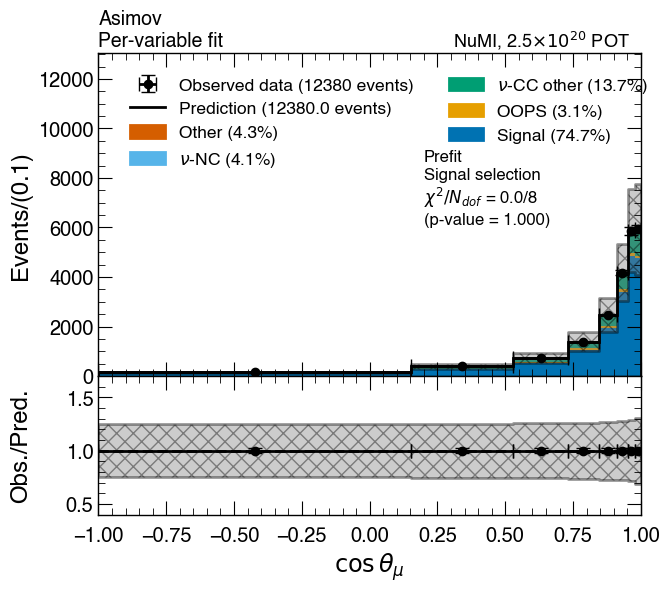

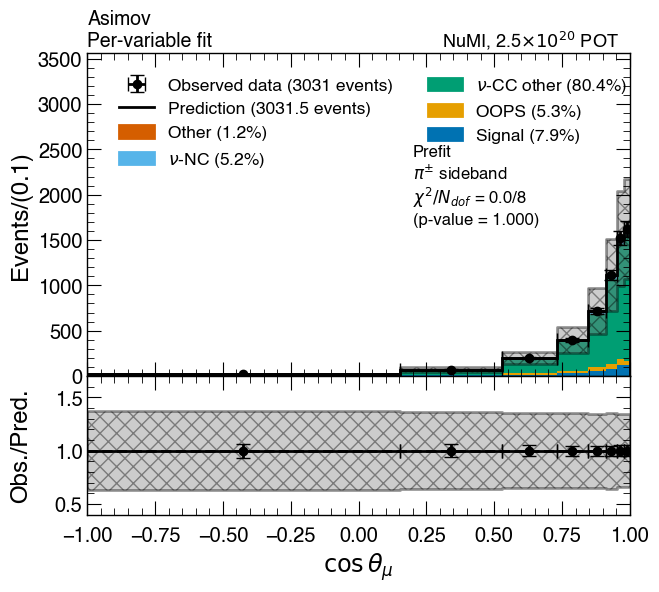

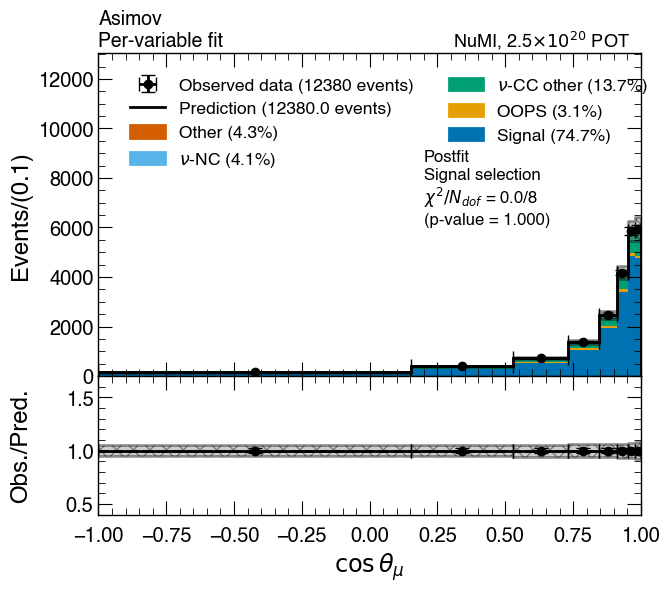

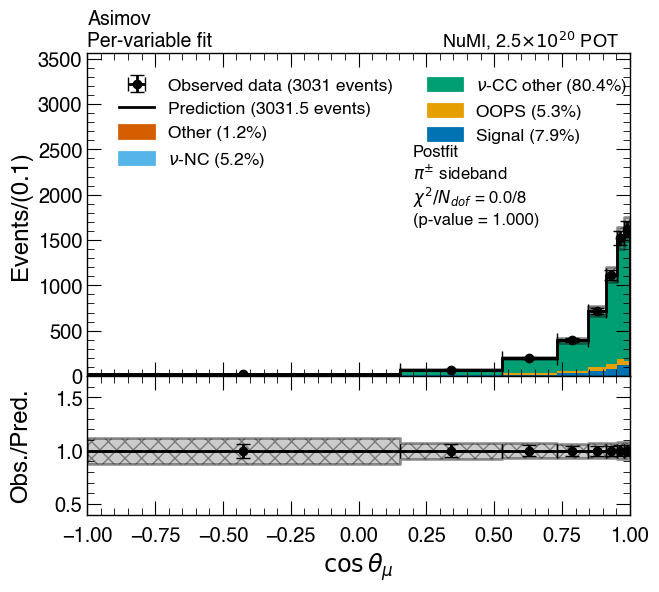

In [61]:
for FitInfo in FitInfos:

    FitKey = FitInfo.Name
    FitLatex = FitInfo.Latex

    for SelectionInfo in SelectionInfos:

        SelectionName = SelectionInfo.Name
        SelectionLatex = SelectionInfo.Latex

        HistTDir = FitTDirs[FitKey][f'samples/histograms/{SelectionName}_{RecoVariableName}/{RecoVariableName}'] \
            if FitKey=='post' \
                else FitTDirs[FitKey][f'plots/histograms/{SelectionName}_{RecoVariableName}/{RecoVariableName}']
        
        # Data

        hist_Data = HistTDir['Data_TH1D'].to_numpy()[0]
        Rate_Data = np.sum(hist_Data)

        # MC

        h_TotalPred = HistTDir['MC_TH1D'].to_numpy()[0]
        Rate_TotalPred = np.sum(h_TotalPred)

        Fracs = []
        hists = []
        Binning = 0
        for SampleCategory in SampleCategories:
            hist = HistTDir['IsSignal/%s/MC_TH1D'%(SampleCategory[0])].to_numpy()

            this_rate = np.sum(hist[0])
            this_frac = this_rate/Rate_TotalPred

            Fracs.append(this_frac)

            hists.append( hist[0] )
            Binning = hist[1]

        BinWidth = np.diff(Binning)/BinNormWidth
        BinWidth_Extended = np.append(BinWidth, BinWidth[-1])

        stackhists = [
            np.sum( np.array( hists[:(len(hists)-i)] ), axis=0) for i in range(len(hists))
        ]

        # Error band from throws

        h_Toy_RelError = np.zeros(len(Binning)-1) # For the band, we need to add one more element..
        ToyHistName = f'histograms/{SelectionName}_{RecoVariableName}_pre_fit_TH1D' if FitKey=='pre' else f'histograms/{SelectionName}_{RecoVariableName}_TH1D'
        uph_Toy = ToyTDirs[FitKey][ToyHistName]

        h_Toy_Mean = uph_Toy.to_numpy()[0]
        h_Toy_AbsError = uph_Toy.errors()
        h_Toy_RelError = h_Toy_AbsError/h_Toy_Mean

        # - Abs
        TotalUnc_AbsUnc = np.multiply(h_TotalPred, h_Toy_RelError)
        TotalUnc_AbsUnc_Band_Hi = h_TotalPred+TotalUnc_AbsUnc
        TotalUnc_AbsUnc_Band_Hi = np.append(TotalUnc_AbsUnc_Band_Hi, TotalUnc_AbsUnc_Band_Hi[-1])
        TotalUnc_AbsUnc_Band_Lo = h_TotalPred-TotalUnc_AbsUnc
        TotalUnc_AbsUnc_Band_Lo = np.append(TotalUnc_AbsUnc_Band_Lo, TotalUnc_AbsUnc_Band_Lo[-1])

        # Covariance matrix
        hname_Cov = 'matrices/covarianceMatrix_TH2D'
        uph_Cov = ToyTDirs[FitKey][hname_Cov]
        h_Cov = uph_Cov.to_numpy()[0]
        CovLabels = uph_Cov.axis(0).labels()
        SubCovIndices = []
        for i_label in range(0, len(CovLabels)):
            Label_SelectionName = CovLabels[i_label].split()[0]
            if FitKey=='post':
                Label_SelectionName = Label_SelectionName.split('/')[0]
            if Label_SelectionName==f'{SelectionName}_{RecoVariableName}':
                SubCovIndices.append(i_label)
        SubCovIndices = np.array(SubCovIndices)
        h_SubCov = h_Cov[SubCovIndices[:, None], SubCovIndices]
        CovDiags = np.diagonal(h_SubCov)

        # draw

        fig, (ax_up, ax_dn) = icarusplot.RatioCanvas()
        fig.set_size_inches(7, 6)

        ## Up pad ##

        # Stacked predictions
        lgs_up = []

        for i_s in range(len(SampleCategories)):

            # i_s-th stack is some of 0, 1, ..., len(sampleInfos)-1-i_s = j_s
            j_s = len(SampleCategories)-1-i_s
            sampleInfo = SampleCategories[j_s]

            Latex = sampleInfo[1]
            Color = sampleInfo[2]
            Rate = np.sum(hists[j_s])

            frac = Fracs[j_s]

            hdl = ax_up.hist(
                Binning[:-1], 
                bins=Binning,
                weights=stackhists[i_s]/BinWidth,
                color=Color, 
            )
            lgs_up.append(
                Patch(color=Color, label='%s (%1.1f%%)' % (Latex, 100. * frac))
            )

        # Total prediction

        ax_up.hist(
            Binning[:-1], 
            bins=Binning,
            weights=h_TotalPred/BinWidth,
            color='k', 
            histtype='step'
        )

        hdl_TotalPred = Line2D([0], [0], color='k', label='Prediction (%1.1f events)'%(Rate_TotalPred), linestyle='-')

        # error band
        ax_up.fill_between(
            Binning,
            TotalUnc_AbsUnc_Band_Hi/BinWidth_Extended,
            TotalUnc_AbsUnc_Band_Lo/BinWidth_Extended,
            step='post',
            color='gray',
            alpha=0.4,
            hatch='xx',
            edgecolor='k',
        )

        # Data
        x_c_data = [ (Binning[i]+Binning[i+1])/2.  for i in range(0, len(Binning)-1) ]
        x_err_data = [ (Binning[i+1]-Binning[i])/2.  for i in range(0, len(Binning)-1) ]
        #histerr_OnBeam_Data = np.sqrt(np.random.poisson(hist_OnBeam_Data)) # poisson?
        histerr_Data = np.sqrt(hist_Data)
        sum_observed = np.sum( hist_Data )
        hdl_data = ax_up.errorbar(
            x_c_data, 
            hist_Data/BinWidth, 
            xerr=x_err_data, 
            yerr=histerr_Data/BinWidth, 
            fmt='ok',
            capsize=5,
            label="Observed data (%d events)"%(Rate_Data),
        )

        # y_max
        y_max = max( 
            np.max(h_TotalPred/BinWidth), 
            np.max(hist_Data/BinWidth) 
        )

        # Add labels, title, legend, and grid
        ax_up.set_ylabel(VariableYTitle)
        ax_up.set_xlim(left=xMin, right=xMax)
        ax_up.set_ylim(top=y_max*2.2)

        lgs_up.insert(0, hdl_TotalPred)
        lgs_up.insert(0, hdl_data)
        ax_up.legend(
            handles=lgs_up, 
            ncols=2, 
            # loc='upper right', 
            # prop={'size': 10.5}
            loc='upper left',
            prop={'size': 12.5},
            bbox_to_anchor=(0.03, 0.98),
        ) #, prop={'size':12.5})

        # Let's calculate chi2
        # - binwidth divided covariance matrix :h_SubCov
        CovForChi2Calc = np.ndarray(h_SubCov.shape)
        for i in range(len(Binning)-1):
            BinWidth_i = np.diff(Binning)[i]
            for j in range(len(Binning)-1):
                BinWidth_j = np.diff(Binning)[j]

                CovForChi2Calc[i, j] = h_SubCov[i, j]*BinWidth_i*BinWidth_j
        for i in range(len(Binning)-1):
            CovForChi2Calc[i, i] += histerr_Data[i]*histerr_Data[i]

        CovInvForChi2Calc= np.linalg.inv(CovForChi2Calc)
        chi2_diag = 0.
        chi2_all = 0.
        for i in range(len(Binning)-1):
            for j in range(len(Binning)-1):
                this_chi2 = (hist_Data[i]-h_TotalPred[i]) * (hist_Data[j]-h_TotalPred[j]) * CovInvForChi2Calc[i,j]
                chi2_all += this_chi2
                if i==j:
                    chi2_diag += this_chi2

        ThisPValue = 1. - chi2.cdf(chi2_all, len(Binning)-1)
        txt_fitstat = r'$\chi^{2}/N_{dof}$'+' = %1.1f/%d\n(p-value = %1.3f)'%(chi2_all, len(Binning)-1, ThisPValue)

        _xrange = ax_up.get_xlim()
        _use_x = _xrange[0] + 0.60*(_xrange[1] - _xrange[0])
        _yrange = ax_up.get_ylim()
        _use_y = _yrange[0] + 0.47*(_yrange[1] - _yrange[0])
        ax_up.text(_use_x, _use_y, f'{FitLatex}\n{SelectionLatex}\n{txt_fitstat}', fontsize=12)
        # ax_up.text(_use_x, _use_y, f'{FitLatex}\n{SelectionLatex}', fontsize=12)

        ## Down pad for the ratio ##

        lgs_dn = []

        # For the band, we need to add one more element..
        TotalUnc_RelUnc_Ratio_Band_Hi = np.append(h_Toy_RelError, h_Toy_RelError[-1])
        TotalUnc_RelUnc_Ratio_Band_Hi = 1.+TotalUnc_RelUnc_Ratio_Band_Hi
        TotalUnc_RelUnc_Ratio_Band_Lo = np.append(h_Toy_RelError, h_Toy_RelError[-1])
        TotalUnc_RelUnc_Ratio_Band_Lo = 1.-TotalUnc_RelUnc_Ratio_Band_Lo

        # draw
        ax_dn.fill_between(
            Binning,
            TotalUnc_RelUnc_Ratio_Band_Hi,
            TotalUnc_RelUnc_Ratio_Band_Lo, 
            step='post',
            color='gray',
            alpha=0.4,
            hatch='xx',
            edgecolor='k',
        )

        # Data points
        hist_Ratio_Data = [
            1. if h_TotalPred[i]==0. else hist_Data[i]/h_TotalPred[i]
            for i in range(h_TotalPred.size)
        ]
        histerr_Ratio_Data = [
            0. if h_TotalPred[i]==0. else histerr_Data[i]/h_TotalPred[i]
            for i in range(h_TotalPred.size)
        ]

        ax_dn.errorbar(
            x_c_data, 
            hist_Ratio_Data, 
            xerr=x_err_data, 
            yerr=histerr_Ratio_Data, 
            fmt='ok', 
            capsize=5,
            label="Data (%d slices)"%(sum_observed),
        )

        ax_dn.axhline(y=1, color='k', linestyle='--')

        ax_dn.set_xlabel(VariableXTitle)
        ax_dn.set_ylabel('Obs./Pred.')
        ax_dn.set_xlim(left=xMin, right=xMax)
        ax_dn.set_ylim(bottom=0.4, top=1.7)
        # ax_dn.set_ylim(bottom=0.85, top=1.15)

        # lgs_dn.append( Patch(color='magenta', label='Stat.') )
        # lgs_dn.append( Patch(color='cyan', label='Stat.+Syst.') )
        # ax_dn.legend(handles=lgs_dn, ncols=2, loc='upper right')

        #AddTextTopLeft(ax_up, r'Fake data; Fe $T_{\pi}$ applied to CC1$\pi$')
        icarusplot.AddTextTopLeft(ax_up, TopLeftLatex)
        icarusplot.POT(ax_up, POTToNormalize)

        OutputPath = f'{PlotBaseDir}/{FitKey}_{SelectionName}_{VariableName}.pdf'
        fig.savefig(OutputPath, bbox_inches='tight')

        # plt.close()

# Pulls

In [62]:
ErrorCalInfos = [
    BaseInfo(Name='Hesse', Latex='Hesse'),
    BaseInfo(Name='Migrad', Latex='Migrad'),
]

In [63]:
for ErrorCalInfo in ErrorCalInfos: 

    ErrorCalName = ErrorCalInfo.Name

    print('- ErrorCalName: ', ErrorCalName)

    if ErrorCalName=='Hesse' and 0:

        # Hessian status

        print('  - Drawing Hessian status..')

        with uproot.open(f_FitOutput) as f:
            tree_hesseStats = f['FitterEngine/postFit/hesseStats']
            Branches = []
            for br in tree_hesseStats.branches:
                Branches.append(br.name)
            df_hesseStats = tree_hesseStats.arrays(Branches, library='pd')

        IsHesseSuccess = df_hesseStats.iloc[0]['hesseSuccess']
        CovMatStatCode = df_hesseStats.iloc[0]['covStatusCode']

        # HESSE Status

        fig_hessestats, ax_hessestats = plt.subplots(figsize=(6,4))

        fig_hessestats.patch.set_visible(False)  # This removes the figure background
        ax_hessestats.tick_params(axis='both', which='both', top=False, bottom=False, right=False, left=False, labelbottom=False, labelleft=False)

        # Adding text to the plot
        ax_hessestats.text(0.1, 0.9, 'IsHesseSuccess = %s'%(IsHesseSuccess), fontsize=12)
        ax_hessestats.text(0.1, 0.8, 'CovMatStatCode = %s'%(CovMatStatCode), fontsize=12)

        outputName = '%s_stats.pdf'%(ErrorCalName)
        fig_hessestats.savefig(f'{PlotBaseDir}/{outputName}', bbox_inches='tight')

        plt.close()

        # Hessian matrices
        CovOrCors = ['Covariance', 'Correlation']
        with uproot.open(f_FitOutput) as f:
            for CovOrCor in CovOrCors:

                print(f'  - Drawing Hessian {CovOrCor} matrix..')

                uh_CovOrCor = f['FitterEngine/postFit/Hesse/hessian/postfit%s_TH2D'%(CovOrCor)]
                h_CovOrCor = uh_CovOrCor.to_numpy()

                fig, ax = plt.subplots(figsize=(100,60))

                # Plot the heatmap
                cax = ax.matshow(h_CovOrCor[0], cmap='coolwarm')

                # Add colorbar
                plt.colorbar(cax)

                cax_lims = cax.get_clim()
                cax_max = max( abs(cax_lims[0]), abs(cax_lims[1]) )
                cax.set_clim(-1.*cax_max, +1*cax_max)

                # Set labels

                param_labels = uh_CovOrCor.axis(0).labels()
                NParams = len(param_labels)

                # ax.set_xticks(np.arange(NParams))  # Set the ticks for each column
                # ax.set_xticklabels(param_labels, rotation=90)  # Replace with custom labels

                ax.set_yticks(np.arange(NParams))  # Set the ticks for each row
                ax.set_yticklabels(param_labels)  # Replace with custom labels
                ax.minorticks_off()

                ax.set_title('%s matrix'%(CovOrCor), fontsize=30)

                outputName = '%s_%s.pdf'%(ErrorCalName, CovOrCor)
                fig.savefig(f'{PlotBaseDir}/{outputName}', bbox_inches='tight')

                plt.close()
    
    FitResultAxisLabel = 'Parameter values'

    ParamSetNames = []

    with uproot.open(f_FitOutput) as f:
        ErrorCalTDir = f[f'FitterEngine/postFit/{ErrorCalName}']
    
    for k in ErrorCalTDir['errors']:
        if '/' in k:
            continue
        else:
            ParamSetNames.append(k.split(';')[0])

    arr_ForOnePull_ParamNames = []
    arr_ForOnePull_Prefit_Vals = []
    arr_ForOnePull_Prefit_Errs = []
    arr_ForOnePull_Postfit_Vals = []
    arr_ForOnePull_Postfit_Errs = []
    for ParamSetName in ParamSetNames:
            
        FitParamValueDir = ErrorCalTDir['errors'][ParamSetName]['values']

        # Get errorband from prefit
        PreFitPullHist = FitParamValueDir['preFitErrors_TH1D']
        PreFitPullHist_Values = PreFitPullHist.to_numpy()[0]
        PreFitPullHist_Errors = PreFitPullHist.errors()

        if 'Template' in ParamSetName:
            PreFitPullHist_Errors = np.zeros( PreFitPullHist_Errors.shape )

        # Post fit
        PostFitPullHist = FitParamValueDir['postFitErrors_TH1D']

        BinLabels = PostFitPullHist.axis().labels()

        ParamNames = [
            ParamSetName+'/'+l
            for l in BinLabels  
        ]

        h_pull = PostFitPullHist.to_numpy()[0]
        h_pullerr = PostFitPullHist.errors()
        Binning = PostFitPullHist.to_numpy()[1]
        x_center = [ (Binning[i]+Binning[i+1])/2.  for i in range(0, len(Binning)-1) ]
        x_err = [ (Binning[i+1]-Binning[i])/2.  for i in range(0, len(Binning)-1) ]

        # For One plot
        for i_p, label in enumerate(BinLabels):
            arr_ForOnePull_ParamNames.append(ParamSetName+'/'+label)
            arr_ForOnePull_Prefit_Vals.append(PreFitPullHist_Values[i_p])
            arr_ForOnePull_Prefit_Errs.append(PreFitPullHist_Errors[i_p])
            arr_ForOnePull_Postfit_Vals.append(h_pull[i_p])
            arr_ForOnePull_Postfit_Errs.append(h_pullerr[i_p])
        NThisParam = len(ParamNames)

        #------------------------------------
        # horizontal plot

        fig, ax = plt.subplots(figsize=(len(Binning), 5))
        
        x_pos = np.arange(NThisParam)

        # Plot prefit (as fill_between)
        ax.bar(
            x_pos, 
            height=2 * np.array(PreFitPullHist_Errors),
            bottom=np.array(PreFitPullHist_Values) - np.array(PreFitPullHist_Errors),
            color="lightcoral",
            alpha=0.6,
            label=r'Prefit ± 1$\sigma$',
            width=1.0,
        )

        # Plot postfit (as error bars)
        ax.errorbar(
            x_pos,
            h_pull,
            xerr=0.5*np.ones_like(x_pos),
            yerr=h_pullerr,
            fmt="o",
            markersize=8,
            color="black",
            capsize=3,
            label="Postfit"
        )

        # Format y-axis
        ax.set_xticks(x_pos)
        ax.set_xticklabels(ParamNames, rotation=90)
        ax.tick_params(axis='x', which='both', length=0, labelsize=10)  # Remove minor ticks
        ax.set_xlim(-0.5, NThisParam - 0.5)  # Strictly limit to parameter range  # Adjust y-axis range  # Top to bottom order

        # Add grid, labels, horizontal boundary lines, and legend
        for x in range(NThisParam):
            ax.axvline(x - 0.5, color="black", linewidth=0.8, alpha=0.5)
            ax.axhline(y=PreFitPullHist_Values[x], color="gray", linestyle="--", linewidth=1, alpha=0.7,
                       xmin=((x-0.5)+0.5)/NThisParam,
                       xmax=((x+0.5)+0.5)/NThisParam
            )
        ax.set_ylabel(FitResultAxisLabel, labelpad=15)

        icarusplot.AddTextTopLeft(ax, ParamSetName)

        if 'Template' in ParamSetName:
            ax.set_ylim(bottom=0)

        outputName = '%s_pulls_horz_%s.pdf'%(ErrorCalName, ParamSetName.replace(' ','_'))

        fig.savefig(f'{PlotBaseDir}/{outputName}', bbox_inches='tight')
        plt.close()

        #------------------------------------

        # vertical plot
        # reverse
        ParamNames = ParamNames[::-1]
        PreFitPullHist_Values = PreFitPullHist_Values[::-1]
        PreFitPullHist_Errors = PreFitPullHist_Errors[::-1]
        h_pull = h_pull[::-1]
        h_pullerr = h_pullerr[::-1]

        fig, ax = plt.subplots(figsize=(5, len(Binning)))
        
        y_pos = np.arange(NThisParam)

        # Plot prefit (as fill_between)
        ax.barh(
            y_pos, 
            width=2 * np.array(PreFitPullHist_Errors),
            left=np.array(PreFitPullHist_Values) - np.array(PreFitPullHist_Errors),
            color="lightcoral",
            alpha=0.6,
            label=r'Prefit ± 1$\sigma$',
            height=1.0,
        )

        # Plot postfit (as error bars)
        ax.errorbar(
            h_pull,
            y_pos,
            xerr=h_pullerr,
            yerr=0.5*np.ones_like(y_pos),
            fmt="o",
            color="black",
            capsize=3,
            label="Postfit",
            markersize=8,
        )

        # Format y-axis
        ax.set_yticks(y_pos)
        ax.set_yticklabels(ParamNames)
        ax.tick_params(axis='y', which='both', length=0, labelsize=10)  # Remove minor ticks
        ax.set_ylim(-0.5, NThisParam - 0.5)  # Strictly limit to parameter range  # Adjust y-axis range  # Top to bottom order

        # Add grid, labels, horizontal boundary lines, and legend
        for y in range(NThisParam):
            ax.axhline(y - 0.5, color="black", linewidth=0.8, alpha=0.5)
            ax.axvline(x=PreFitPullHist_Values[y], color="gray", linestyle="--", linewidth=1, alpha=0.7,
                       ymin=((y-0.5)+0.5)/NThisParam,
                       ymax=((y+0.5)+0.5)/NThisParam
            )
        ax.set_xlabel(FitResultAxisLabel, labelpad=15)
        ax.xaxis.set_label_position('top')
        ax.xaxis.tick_top()
        
        if 'Template' in ParamSetName:
            ax.set_xlim(left=0)

        outputName = '%s_pulls_vert_%s.pdf'%(ErrorCalName, ParamSetName.replace(' ','_'))

        fig.savefig(f'{PlotBaseDir}/{outputName}', bbox_inches='tight')
        plt.close()

    # one big plot

    arr_ForOnePull_ParamNames = arr_ForOnePull_ParamNames[::-1]
    arr_ForOnePull_Prefit_Vals = arr_ForOnePull_Prefit_Vals[::-1]
    arr_ForOnePull_Prefit_Errs = arr_ForOnePull_Prefit_Errs[::-1]
    arr_ForOnePull_Postfit_Vals = arr_ForOnePull_Postfit_Vals[::-1]
    arr_ForOnePull_Postfit_Errs = arr_ForOnePull_Postfit_Errs[::-1]

    NTotalParam = len(arr_ForOnePull_ParamNames)

    fig, ax = plt.subplots(figsize=(10, 22))
    y_pos = np.arange(NTotalParam)

    # Plot prefit (as fill_between)
    ax.barh(
        y_pos, 
        width=2 * np.array(arr_ForOnePull_Prefit_Errs),
        left=np.array(arr_ForOnePull_Prefit_Vals) - np.array(arr_ForOnePull_Prefit_Errs),
        color="lightcoral",
        alpha=0.6,
        label=r'Prefit ± 1$\sigma$',
        height=1.0,
    )

    # Plot postfit (as error bars)
    ax.errorbar(
        arr_ForOnePull_Postfit_Vals,
        y_pos,
        xerr=arr_ForOnePull_Postfit_Errs,
        yerr=0.5*np.ones_like(y_pos),
        fmt="o",
        color="black",
        capsize=3,
        label="Postfit",
        # markersize=8,
    )

    # Format y-axis
    ax.set_yticks(y_pos)
    ax.set_yticklabels(arr_ForOnePull_ParamNames)
    ax.tick_params(axis='y', which='both', length=0, labelsize=10)  # Remove minor ticks
    ax.set_ylim(-0.5, NTotalParam - 0.5)  # Strictly limit to parameter range  # Adjust y-axis range  # Top to bottom order

    # Add grid, labels, horizontal boundary lines, and legend
    for y in range(NTotalParam):
        ax.axhline(y - 0.5, color="black", linewidth=0.8, alpha=0.5)
        ax.axvline(x=arr_ForOnePull_Prefit_Vals[y], color="gray", linestyle="--", linewidth=1, alpha=0.7, 
                   ymin=((y-0.5)+0.5)/NTotalParam,
                   ymax=((y+0.5)+0.5)/NTotalParam
        )
    ax.set_xlabel(FitResultAxisLabel, labelpad=15)
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()

    outputName = f'{ErrorCalName}_pulls_horz_oneplot_{VariableName}.pdf'
    fig.savefig(f'{PlotBaseDir}/{outputName}', bbox_inches='tight')
    plt.close()


- ErrorCalName:  Hesse
- ErrorCalName:  Migrad


# X-sec

<>:116: SyntaxWarning: invalid escape sequence '\c'
<>:116: SyntaxWarning: invalid escape sequence '\c'
/var/folders/1d/yt_r7jc56gj74d9y7tldbk280000gn/T/ipykernel_8902/1574399070.py:116: SyntaxWarning: invalid escape sequence '\c'
  label=f'{GeneratorLatex} ($\chi^{2}/ndof$ = {this_generator_chi2:.1f}/{len(h_xsec)})',


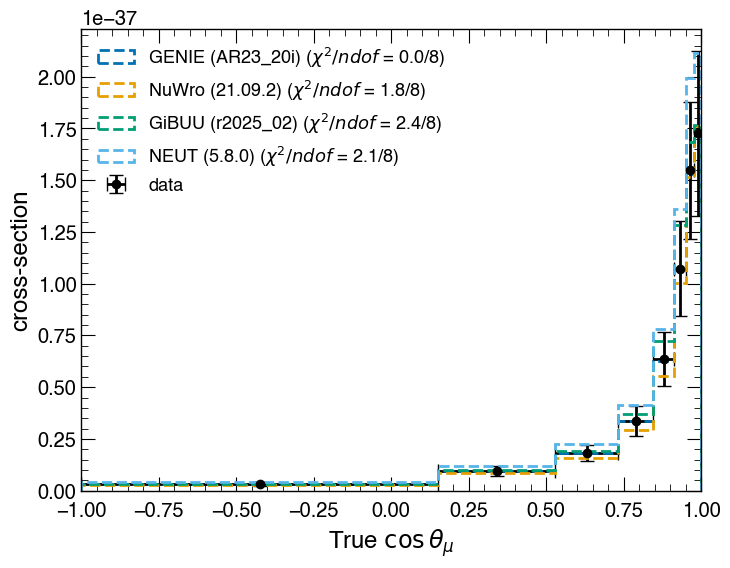

In [64]:
fig, ax = plt.subplots(figsize=(8,6))

# y_max = -1

variableInfo = VariableInfos[TrueVariableName]

PlotVariableName = variableInfo.Name
VariableXTitle = variableInfo.GetXaxisTitle()

VariableYTitle = 'cross-section'
if TrueVariableName=='TruedeltaPT':
    VariableYTitle = r'$\frac{d \sigma}{d \delta p_{T}}$ $\frac{cm^{2}}{(GeV/c) Ar}$'
if TrueVariableName=='TruedeltaalphaT':
    VariableYTitle = r'$\frac{d \sigma}{d \delta \alpha_{T}}$ $\frac{cm^{2}}{(degree) Ar}$'
if TrueVariableName=='cosmu':
    VariableYTitle = r'$\frac{d \sigma}{d \cos{\theta_{\mu}}}$ $\frac{cm^{2}}{Ar}$'
if TrueVariableName=='cosmup':
    VariableYTitle = r'$\frac{d \sigma}{d \cos{\theta_{\mu,p}}}$ $\frac{cm^{2}}{Ar}$'

BinNormWidth = variableInfo.BinNormWidth
xMin = variableInfo.xMin
xMax = variableInfo.xMax

# Extracted

XsecFilepath = f'{XsecOutputBaseDir}/output_{FitDataType}_{FitConfigType}_{VariableName}.root'

with uproot.open(XsecFilepath) as f:

    # To get the binning
    h_for_binning = f[f'calcXsec/plots/histograms/TrueSignal_{TrueVariableName}/{TrueVariableName}/MC_TH1D']
    Binning = h_for_binning.to_numpy()[1]

    BinCenters = [
        (Binning[i]+Binning[i+1])/2.
        for i in range(len(Binning)-1)
    ]
    BinErrors = [
        (Binning[i+1]-Binning[i])/2.
        for i in range(len(Binning)-1)
    ]

    # x-sec hist

    hist_xsec = f[f'calcXsec/histograms/TrueSignal_{TrueVariableName}_TH1D']

    h_xsec = hist_xsec.to_numpy()[0]
    h_xsec_err = hist_xsec.errors()

ax.errorbar(
    BinCenters, 
    h_xsec, 
    xerr=BinErrors,
    yerr=h_xsec_err, 
    fmt='ok',
    capsize=5,
    label='data'
)

xsec_cov = f['calcXsec/matrices/covarianceMatrix_TH2D'].to_numpy()[0]
xsec_invcov = np.linalg.inv(xsec_cov)

# theory
TheoryXsecBaseDir = '/Users/jskim/docker/volumes/nusyst/work/250605_ReworkGeneratorPrediction/xsecs'

GeneratorInfos = [
    ['GENIE', '250611_GENIE_1MEvents', 'AR23_20i_00_000', 'GENIE (AR23_20i)'],
    ['NuWro', '250616_NuWro_1MEvents', '21.09.2', 'NuWro (21.09.2)'],
    ['GiBUU', '250617_GiBUU_Try0', 'r2025_02', 'GiBUU (r2025_02)'],
    ['NEUT', '250625_NEUT_1M', '5.8.0', 'NEUT (5.8.0)'],
    # ['NEUT', '250215_1MEvents', '5.8.0', 'NEUT (5.8.0), old'],
]
for i_G, GeneratorInfo in enumerate(GeneratorInfos):

    GeneratorName = GeneratorInfo[0]
    GeneratorJobName = GeneratorInfo[1]
    GeneratorConfig = GeneratorInfo[2]
    GeneratorLatex = GeneratorInfo[3]

    this_csv = f'{TheoryXsecBaseDir}/xsec_{GeneratorName}_{GeneratorConfig}_{GeneratorJobName}_True{VariableName}_AnaBin.csv'
    this_df = pd.read_csv(this_csv)
    BinCenters, BinErrors, h_diffxsec_sum = this_df['x_center'].to_numpy(), this_df['x_err'].to_numpy(), this_df['xsec'].to_numpy()

    NBinsForChi2 = len(h_xsec)-1 if TrueVariableName=='TruedeltaPT' else len(h_xsec)
    this_generator_chi2 = 0
    for ix in range(NBinsForChi2):

        for iy in range(NBinsForChi2):
            
            # if ix!=iy:
            #     continue

            this_generator_chi2 += ( h_diffxsec_sum[ix]-h_xsec[ix] ) * xsec_invcov[ix, iy] * ( h_diffxsec_sum[iy]-h_xsec[iy] )

    # ax.plot(
    #     BinCenters, 
    #     h_diffxsec_sum,
    #     label=f'{GeneratorLatex} ($\chi2^{2}/ndof$ = {this_generator_chi2:.1f}/{len(h_xsec)})',
    # )

    # ax.errorbar(
    #     BinCenters, 
    #     h_diffxsec_sum,
    #     xerr=BinErrors, 
    #     fmt='o', 
    #     capsize=5,
    #     label=f'{GeneratorLatex} ($\chi^{2}/ndof$ = {this_generator_chi2:.1f}/{len(h_xsec)})',
    # )

    ax.hist(
        Binning[:-1], 
        bins=Binning,
        weights=h_diffxsec_sum,
        histtype='step',
        linestyle='--',
        label=f'{GeneratorLatex} ($\chi^{2}/ndof$ = {this_generator_chi2:.1f}/{len(h_xsec)})',
    )



y_max = max( y_max, np.max(h_xsec+h_xsec_err) )

ax.legend(
    fontsize=13,
    # loc='upper left',
    # ncol=2,
)

ax.set_xlabel(VariableXTitle)
ax.set_xlim(left=xMin, right=xMax)

ax.set_ylabel(VariableYTitle)
ax.set_ylim(bottom=0)

outputName = f'xsec_{TrueVariableName}.pdf'

fig.savefig(f'{PlotBaseDir}/{outputName}', bbox_inches='tight')

# p-value from toy fits

In [65]:
ToyFitBranches = [
    'totalLikelihoodAtBestFit',
    'nbDegreeOfFreedom',
]

In [66]:
with uproot.open(f_FitOutput) as f:
    DataFitResult = f['FitterEngine/postFit/bestFitStats'].arrays(ToyFitBranches, library='pd')

In [77]:
NToyFits = 48

In [78]:
ToyFitsOutputDir = f'{WD}/output/{JobName}/ToyFit/{FitDataType}_{FitConfigType}_{VariableName}'

In [79]:
ToyFitResults = []
for i_toy in range(NToyFits):
    with uproot.open(f'{ToyFitsOutputDir}/output_Toy_{i_toy}.root') as f:
        df_toyfit_fitstat = f['FitterEngine/postFit/bestFitStats'].arrays(ToyFitBranches, library='pd')
        ToyFitResults.append(df_toyfit_fitstat.iloc[0])

In [80]:
TotalLLHs = [ ToyFitResults[i]['totalLikelihoodAtBestFit'] for i in range(len(ToyFitResults)) ]
TotalLLHs = np.array(TotalLLHs)

Text(0.5, 0, 'Total LLH')

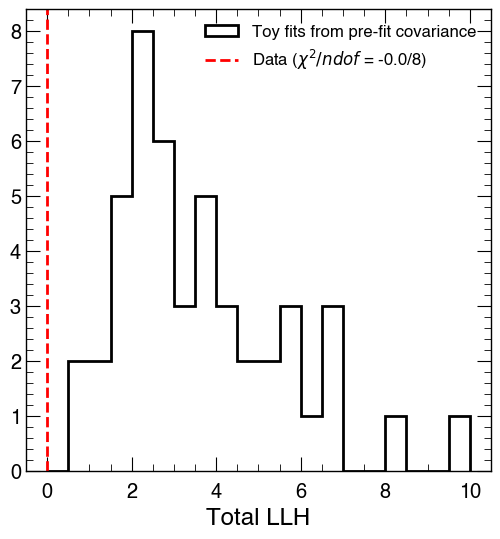

In [81]:
fig, ax = plt.subplots(figsize=(6,6))

LLH_bins = np.linspace(0, 10, 100+1)
LLH_bins = np.linspace(0, 10, 20+1)


h_ToyFit_TotalLLHs = np.histogram(
    TotalLLHs,
    bins=LLH_bins, 
)[0]
area_ToyFit_TotalLLHs = np.sum(h_ToyFit_TotalLLHs)

ax.hist(
    LLH_bins[:-1], 
    bins=LLH_bins,
    weights=h_ToyFit_TotalLLHs,
    color='k', 
    histtype='step',
    label='Toy fits from pre-fit covariance',
)

# ax.hist(
#     TotalLLHs,
#     bins=LLH_bins, 
#     histtype='step', 
#     color='k',
#     label='Toy fits from pre-fit covariance'
# )

DataFitResult_LLH = DataFitResult['totalLikelihoodAtBestFit'].iloc[0]
ax.axvline(
    x=DataFitResult_LLH,
    color='r',
    linestyle='--',
    label=r'Data ($\chi^{2}/ndof$ = %1.1f/%d)'%(DataFitResult_LLH, len(Binning)-1)
)

# chi2pdf_df = 19
chi2pdf_df = DataFitResult['nbDegreeOfFreedom'].iloc[0]
chi2pdf_x = np.linspace(chi2.ppf(0.01, chi2pdf_df),
                chi2.ppf(0.99, chi2pdf_df), 100)
chi2pdf_y = chi2.pdf(chi2pdf_x, chi2pdf_df)
area_chi2pdf = np.sum(chi2pdf_y)
pvalue_from_chi2_dist = 1 - chi2.cdf(DataFitResult_LLH, chi2pdf_df)
# ax.plot(
#     chi2pdf_x,
#     chi2pdf_y/area_chi2pdf*area_ToyFit_TotalLLHs,
#     'r-',
#     lw=5,
#     alpha=0.6,
#     label='chi2 pdf (p-value = %1.3f)'%(pvalue_from_chi2_dist)
# )



ax.legend()

ax.set_xlabel('Total LLH')